In [1]:
import ROOT
from ROOT import TCanvas, TH1F
from ROOTDefs import tau_formatted_root_directory
#from NNDefs import build_and_train_class_nn
from LayersDefs import get_signal_and_background_frames, calculate_derived_et_columns, roc_efficiencies, predict_nn_on_all_frame
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import os
import uproot

random.seed(6)
np.random.seed(6)

Welcome to JupyROOT 6.14/02


In [2]:
signal_frame, background_frame = get_signal_and_background_frames()

calculate_derived_et_columns(signal_frame, background_frame)

In [3]:
all_frame = pd.concat([signal_frame, background_frame], sort=True)

In [12]:
classes = np.unique(all_frame['IsSignal'].values)

class_weights = class_weight.compute_class_weight('balanced', classes, all_frame['IsSignal'].values)

class_weight_dict = {classes[0]:class_weights[0], classes[1]:class_weights[1]}

print(np.unique(all_frame['IsSignal'].values))
print(class_weights)
print(class_weight_dict)

[0 1]
[0.52952975 8.96603727]
{0: 0.5295297542325016, 1: 8.966037273173123}


In [5]:
signal_efficiencies, background_efficiencies = roc_efficiencies(signal_frame[['TotalEt']], 
                                                                background_frame[['TotalEt']], 
                                                                300, 
                                                                target_90percent_signal=1)

In [ ]:
predicted_signal_frame, predicted_background_frame, _ = predict_nn_on_all_frame(all_frame, 
                                                                                ['L0Et', 'L1Et', 'L2Et', 'L3Et', 'HadEt'], 
                                                                                ['IsSignal'])

In [7]:
basic_train_signal_efficiencies, basic_train_background_efficiencies = roc_efficiencies(predicted_signal_frame[['NNOutputValue']], 
                                                                                        predicted_background_frame[['NNOutputValue']], 
                                                                                        300, 
                                                                                        target_90percent_signal=1)

In [8]:
downsample_background_frame = background_frame.sample(n=len(signal_frame))
downsample_all_frame = pd.concat([signal_frame, downsample_background_frame], sort=True)

predicted_downsample_signal_frame, predicted_downsample_background_frame, _ = predict_nn_on_all_frame(downsample_all_frame, 
                                                                                                      ['L0Et', 'L1Et', 'L2Et', 'L3Et', 'HadEt'], 
                                                                                                      ['IsSignal'])

downsample_signal_efficiencies, downsample_background_efficiencies = roc_efficiencies(predicted_downsample_signal_frame[['NNOutputValue']], 
                                                                                      predicted_downsample_background_frame[['NNOutputValue']], 
                                                                                      300, 
                                                                                      target_90percent_signal=1)

In [9]:
predicted_weighted_signal_frame, predicted_weighted_background_frame, _ = predict_nn_on_all_frame(all_frame, ['L0Et', 'L1Et', 'L2Et', 'L3Et', 'HadEt'], ['IsSignal'],
                                                                                                  class_weight=class_weight_dict)

weighted_signal_efficiencies, weighted_background_efficiencies = roc_efficiencies(predicted_weighted_signal_frame[['NNOutputValue']], 
                                                                                      predicted_weighted_background_frame[['NNOutputValue']], 
                                                                                      300, 
                                                                                      target_90percent_signal=1)

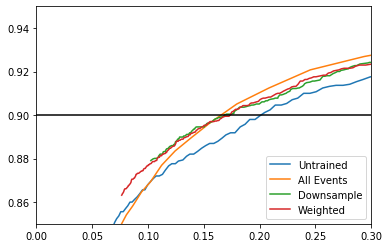

In [10]:
plt.plot(background_efficiencies, signal_efficiencies, label='Untrained')
plt.plot(basic_train_background_efficiencies, basic_train_signal_efficiencies, label='All Events')
plt.plot(downsample_background_efficiencies, downsample_signal_efficiencies, label='Downsample')
plt.plot(weighted_background_efficiencies, weighted_signal_efficiencies, label='Weighted')
plt.plot([0, 1], [0.9, 0.9], color='k')
plt.legend(loc='lower right')
plt.xlim(0, 0.3)
plt.ylim(0.85, 0.95)
plt.show()